In [1]:
import os
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
from xai import read_data, read_shuffled_data, compare_exp_testset
from xai import plot_shuffled_map, plot_r_single_sample, plot_all_r_vs_k
from correlation_coefficient import compute_power

/usr/local/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
base_output_dir = "../output/" # Meanwhile I have my own output directory with GAN results
names = ['test', 'xai_exp_random', 
         'xai_exp_random_ha', 'xai_exp_random_oiii' ]
results_dir = "../output/xai_results/"
model = f"pix2pix_2_bs4_ep1_lambda1000_vanilla"
nrun = 100
nindex = 1
suffix_list = [ "run{:d}_index{:d}".format(i, j) for i in range(nrun) for j in range(nindex) ]
ref_dir = os.path.join(base_output_dir, names[0])
exp1_dir = os.path.join(base_output_dir, names[1])
exp2_dir = os.path.join(base_output_dir, names[2])
exp3_dir = os.path.join(base_output_dir, names[3])

In [3]:
df = read_shuffled_data(exp1_dir)

In [4]:
df

,obs,realA,realB,p_s,p_tA,p_tB,rec,fakeA,fakeB
0,"[[3.219330782338235e-08, 2.8971048269429372e-0...","[[2.4782103767371394e-08, 2.1227870145433785e-...","[[7.411204056010957e-09, 7.743178123995586e-09...","[[8.730708e-09, 9.156143e-09, 9.77461e-09, 1.0...","[[8.075383e-09, 8.388948e-09, 8.815285e-09, 9....","[[6.55325e-10, 7.671956e-10, 9.593242e-10, 1.2...","[[1.541035e-08, 8.26148e-09, 2.5434144e-08, 1....","[[4.9540617e-08, 3.675672e-08, 4.4748997e-08, ...","[[-3.4130267e-08, -2.849524e-08, -1.9314854e-0..."


In [5]:
def plot_power_spectra(p_ha, p_oiii):
    p_ha[0:6] = 0
    p_oiii[0:6] = 0
    
    plt.figure(figsize=(10, 6))
    # power spectra
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim([0.02, 20])
    labels = [ "Ha", "OIII" ]
    snames = [ "z1.3_ha", "z2.0_oiii" ]
    for i, sname in enumerate(snames):
        fname = f"/mnt/data_cat4/moriwaki/IM2IM/calculation/output/ps_{sname}_{model}.txt"
        data = np.loadtxt(fname)
        k = data[:,0]
        true = data[:,1]
        s_true = data[:,2]
        pred = data[:,3]
        s_pred = data[:,4]

        plt.plot(k, true, label=f"true {labels[i]}")
        plt.fill_between(k, true+s_true, true-s_true)
        plt.errorbar(k, pred, s_pred, fmt=".", label=f"pred {labels[i]}")
    plt.plot(k, p_ha, 'b', linestyle=':', label='sample Ha')
    plt.plot(k, p_oiii, 'orange', linestyle=':', label='sample OIII')
    plt.legend()

In [6]:
log_bins=True
nbins = 30
boxlength= 102.4
c = 1
print(df.columns[c])
image1 = df[df.columns[c]].values[0]
P1, k, _ = compute_power(image1, boxlength=boxlength, nbins=nbins, log_bins=log_bins)
P1 = 2.0*np.pi*P1*k[:-1]*k[:-1]
c = 2
print(df.columns[c])
image2 = df[df.columns[c]].values[0]
P2, k, _ = compute_power(image2, boxlength=boxlength, nbins=nbins, log_bins=log_bins)
P2 = 2.0*np.pi*P1*k[:-1]*k[:-1]

realA
realB


/home/scarlet/IM2IM/explain/correlation_coefficient.py:70: UserWarning: One or more radial bins had no cell within it. Use a smaller nbins.
  warnings.warn("One or more radial bins had no cell within it. Use a smaller nbins.")
/home/scarlet/IM2IM/explain/correlation_coefficient.py:76: RuntimeWarning: invalid value encountered in true_divide
  mean = np.bincount(indx, weights=np.real(field.flatten()), minlength=len(bins)+1)[1:-1] / sumweights


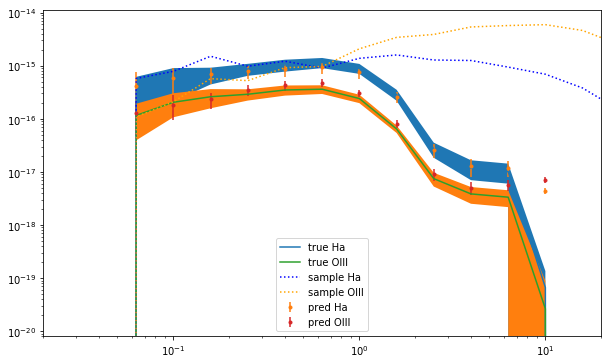

In [7]:
plot_power_spectra(P1, P2)

In [8]:
suffix=f"run0_index0"
f_realA = f"/mnt/data_cat4/moriwaki/IM2IM/val_data/{suffix}_z1.3_ha.fits"
f_realB = f"/mnt/data_cat4/moriwaki/IM2IM//val_data/{suffix}_z2.0_oiii.fits"
f_real = [ f_realA, f_realB ]
raw_r  = [ fits.open( f )[0].data for f in f_real ]

In [9]:
P1, k, _ = compute_power(raw_r[0], boxlength=boxlength, nbins=nbins, log_bins=log_bins)
P1 = 2.0*np.pi*P1*k[:-1]*k[:-1]
P2, k, _ = compute_power(raw_r[1], boxlength=boxlength, nbins=nbins, log_bins=log_bins)
P2 = 2.0*np.pi*P1*k[:-1]*k[:-1]

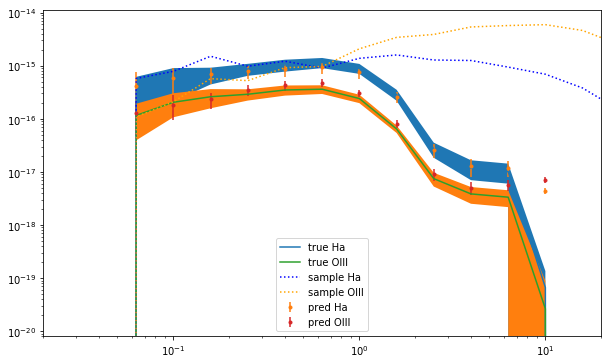

In [10]:
plot_power_spectra(P1, P2)

In [ ]:
nbins=10
r_mix_list, r_ha_list, r_oiii_list = compare_exp_testset(ref_dir, exp1_dir, nbins=nbins, log_bins=True)
plot_all_r_vs_k(r_mix_list, results_dir, title="Comparison of reconstructed mixed signals")

In [ ]:
r_mix_list, r_ha_list, r_oiii_list = compare_exp_testset(ref_dir, exp2_dir, nbins=nbins, log_bins=True)
plot_all_r_vs_k(r_oiii_list, results_dir, title="Comparison of reconstructed OIII signals")

In [ ]:
r_mix_list, r_ha_list, r_oiii_list = compare_exp_testset(ref_dir, exp2_dir, nbins=nbins, log_bins=True)
plot_all_r_vs_k(r_oiii_list, results_dir, title="Comparison of reconstructed Halpha signals")

In [ ]:
suffix=f"run3_index0"
df = read_shuffled_data(exp1_dir, suffix=suffix)
plot_shuffled_map(df, results_dir)
data_exp1 = read_data(exp1_dir, suffix=suffix, ldict=True)
plot_r_single_sample(data_exp1, suffix, log_bins=True)

In [ ]:
df = read_shuffled_data(exp2_dir, suffix=suffix)
plot_shuffled_map(df, results_dir)
data_exp2 = read_data(exp2_dir, suffix=suffix, ldict=True)
plot_r_single_sample(data_exp2, suffix, log_bins=True)

In [ ]:
df = read_shuffled_data(exp3_dir, suffix=suffix)
plot_shuffled_map(df, results_dir)
data_exp3 = read_data(exp3_dir, suffix=suffix, ldict=True)
plot_r_single_sample(data_exp3, suffix, log_bins=True)